In [3]:
import h5py
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from keras.models import *
from keras.layers import *
from keras.preprocessing.image import *
from keras.callbacks import *
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model
import matplotlib.pyplot as plt
import os

np.random.seed(2018)


/home/wson/anaconda3/envs/tf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
def plot_history(history):
    # list all data in history
    # print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### Read feature：

In [5]:
def read_feature():
    h5_file = "feature_Xception.h5"

    with h5py.File(h5_file, 'r') as h:
        X_pretrain = np.array(h['pretrain'])
        y_pretrain = np.array(h['pretrain_label'])
        X_finetune = np.array(h['finetune'])
        y_finetune = np.array(h['finetune_label'])
        X_val = np.array(h['finetune'])
        y_val = np.array(h['finetune_label'])
        X_test = np.array(h['test'])

    X_train = np.concatenate(X_pretrain, X_finetune)
    y_train = np.concatenate(y_pretrain, y_finetune)

    X_train, y_train = shuffle(X_train, y_train)
    
    return X_train, y_train, X_val, y_val


In [ ]:
X_train, y_train, X_val, y_val = read_feature()

In [6]:
print(X_train.shape)

(24895, 2048)


### Model adjustment:

In [7]:
def build_model(input_shape, drop_prob: float, lr=1e-2):
    input_tensor = Input(input_shape)
    x = Dropout(drop_prob)(input_tensor)
    x = Dense(1, activation='sigmoid', name='top_sigmoid')(x)
    model = Model(input_tensor, x)

    opt = optimizers.Adam(lr=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [29]:
model = build_model(X_train.shape[1:], 0.7, lr=1e-3)

In [30]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min'),
             ModelCheckpoint(filepath='top_model_Xception.h5', monitor='val_loss', verbose=0, save_best_only=True)]

history = model.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_val, y_val), callbacks=callbacks)

Train on 19916 samples, validate on 4979 samples
Epoch 1/20
19916/19916 [==============================] - 2s 77us/step - loss: 0.1551 - acc: 0.9645 - val_loss: 0.0464 - val_acc: 0.9928
Epoch 2/20
19916/19916 [==============================] - 1s 40us/step - loss: 0.0429 - acc: 0.9919 - val_loss: 0.0295 - val_acc: 0.9932
Epoch 3/20
19916/19916 [==============================] - 1s 42us/step - loss: 0.0308 - acc: 0.9937 - val_loss: 0.0244 - val_acc: 0.9934
Epoch 4/20
19916/19916 [==============================] - 1s 44us/step - loss: 0.0276 - acc: 0.9936 - val_loss: 0.0216 - val_acc: 0.9938
Epoch 5/20
19916/19916 [==============================] - 1s 40us/step - loss: 0.0233 - acc: 0.9942 - val_loss: 0.0201 - val_acc: 0.9942
Epoch 6/20
19916/19916 [==============================] - 1s 39us/step - loss: 0.0219 - acc: 0.9938 - val_loss: 0.0192 - val_acc: 0.9940
Epoch 7/20
19916/19916 [==============================] - 1s 42us/step - loss: 0.0216 - acc: 0.9938 - val_loss: 0.0184 - val_acc:

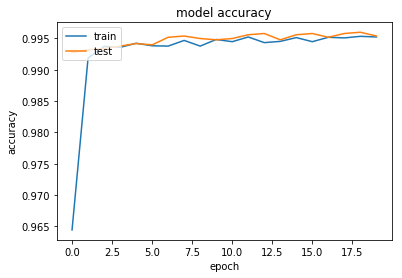

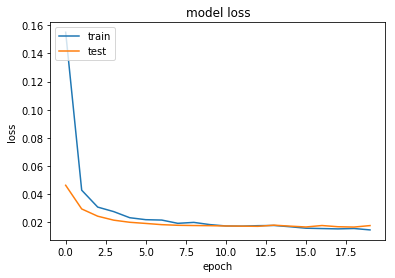

In [31]:
plot_history(history)

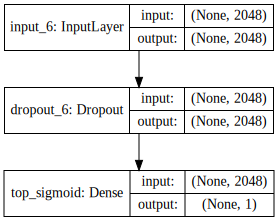

In [18]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### Train in total training data:

In [32]:
model = build_model(X_train.shape[1:], 0.7, lr=1e-3)

In [33]:
model.fit(X_train, y_train, batch_size=128, epochs=19, validation_split=0)

Epoch 1/19
24895/24895 [==============================] - 2s 61us/step - loss: 0.1426 - acc: 0.9674
Epoch 2/19
24895/24895 [==============================] - 1s 41us/step - loss: 0.0388 - acc: 0.9925
Epoch 3/19
24895/24895 [==============================] - 1s 33us/step - loss: 0.0294 - acc: 0.9929
Epoch 4/19
24895/24895 [==============================] - 1s 32us/step - loss: 0.0250 - acc: 0.9939
Epoch 5/19
24895/24895 [==============================] - 1s 35us/step - loss: 0.0229 - acc: 0.9942
Epoch 6/19
24895/24895 [==============================] - 1s 40us/step - loss: 0.0211 - acc: 0.9939
Epoch 7/19
24895/24895 [==============================] - 1s 31us/step - loss: 0.0198 - acc: 0.9947
Epoch 8/19
24895/24895 [==============================] - 1s 30us/step - loss: 0.0193 - acc: 0.9948
Epoch 9/19
24895/24895 [==============================] - 1s 31us/step - loss: 0.0187 - acc: 0.9947
Epoch 10/19
24895/24895 [==============================] - 1s 32us/step - loss: 0.0193 - acc: 0.9942

### Predict:

In [25]:
y_pred = model.predict(X_test, verbose=1)


12500/12500 [==============================] - 1s 59us/step


In [28]:
y_pred_clip = y_pred.clip(min=0.005, max=0.995)

In [29]:
df = pd.read_csv("sampleSubmission.csv")

image_size = (299, 299)
gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("test", image_size, shuffle=False, 
                                         batch_size=64, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind(os.sep)+1:fname.rfind('.')])
    df.loc[index-1, ['label']] = y_pred_clip[i]

df.to_csv('pred.csv', index=None)
df.head(10)

Found 12500 images belonging to 1 classes.


,id,label
0,1,0.9995
1,2,0.9995
2,3,0.9995
3,4,0.9995
4,5,0.0005
5,6,0.0005
6,7,0.0005
7,8,0.0005
8,9,0.0005
9,10,0.0005
